In [192]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from sklearn import preprocessing

In [199]:
# Import data
skill_lookup = {
    1: "Novice",
    2: "Novice",
    3: None,
    4: "Proficient",
    5: "Proficient",
    6: None,
    7: "Expert"
}
league_lookup = {
    1: "Bronze",
    2: "Silver",
    3: "Gold",
    4: "Platinum",
    5: "Diamond",
    6: "Master",
    7: "Grandmaster"
}
# WIN
data = pd.read_csv("all_stats_win.csv")
data = data.drop(["Unnamed: 0", "game_id"], 1)
data["cpm"] = data.apply(lambda r: r['cps']*60, axis = 1)
data["rel_cpm"] = data.apply(lambda r: r['rel_cps']*60, axis = 1)
data_by_rank = [data[data['rank'] == rank] for rank in league_lookup.keys()]

# SKILL
data_uid_skill = pd.read_csv("all_stats_skill.csv")
data_uid_skill = data_uid_skill.drop(["Unnamed: 0", "game_id"], 1)
data_uid_skill["cpm"] = data_uid_skill.apply(lambda r: r['cps']*60, axis = 1)
data_uid_skill["rel_cpm"] = data_uid_skill.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_skill = data_uid_skill[data_uid_skill['rank'].isin([1, 2, 4, 5, 7])].copy()
data_uid_skill["skill"] = data_uid_skill.apply(lambda r: skill_lookup[r['rank']], axis = 1)
data_uid_skill = data_uid_skill.groupby(["uid", "skill", "win"], as_index = False).mean()
data_uid_skill = data_uid_skill.groupby('skill', as_index = False).apply(lambda r: r.sample(n = 3000))


/tmp/ipykernel_33513/1154235534.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop(["Unnamed: 0", "game_id"], 1)
/tmp/ipykernel_33513/1154235534.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_uid_skill = data_uid_skill.drop(["Unnamed: 0", "game_id"], 1)


In [201]:
# RANK
data_uid_rank = pd.read_csv("all_stats_skill.csv") 
data_uid_rank = data_uid_rank.drop(["Unnamed: 0", "game_id"], 1)
data_uid_rank["cpm"] = data_uid_rank.apply(lambda r: r['cps']*60, axis = 1)
data_uid_rank["rel_cpm"] = data_uid_rank.apply(lambda r: r['rel_cps']*60, axis = 1)
data_uid_rank = data_uid_rank[data_uid_rank['rank'].isin([1, 2, 3, 4, 5, 6, 7])].copy()
data_uid_rank = data_uid_rank.groupby(["uid", "rank", "win"], as_index = False).mean()
data_uid_rank = data_uid_rank.groupby('rank', as_index = False).apply(lambda r: r.sample(n = 800))
data_uid_rank['rank'] = pd.Categorical(data_uid_rank['rank'])

/tmp/ipykernel_33513/3145741242.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_uid_rank = data_uid_rank.drop(["Unnamed: 0", "game_id"], 1)


In [85]:
data_uid_skill.columns

Index(['uid', 'skill', 'race', 'win', 'rank', 'scout_freq', 'scout_rel_freq',
       'scout_count', 'scout_rel_count', 'scout_freq_fb', 'scout_mb',
       'scout_first', 'apm', 'rel_apm', 'cps', 'rel_cps', 'peace_rate',
       'battle_rate', 'macro_util', 'rel_macro_util', 'game_length',
       'rel_total_army', 'cpm', 'rel_cpm'],
      dtype='object')

In [217]:
def mean_2darray(arr_list):
    res = arr_list[0]
    for i in range(1, len(arr_list)):
        res += arr_list[i]
    return res/len(arr_list)
    
def powerset(s):
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]
        
def score_est(est, X, y, cv):
    X_sel = X
    selector = RFECV(est, step=1, cv=cv)
    selector.fit(X, y)
    X_sel = selector.transform(X)
    # score for these params is CV score fitting on X_sel
    return np.mean(cross_val_score(est, X_sel, y, cv=cv)), selector.get_support()

def plot_features_importance(plot_info, skill = False, rank = False):
    rank_index = 1
    plot_index = 1
    for plot_info_by_rank in plot_info:
        rank = league_lookup[rank_index]
        feature_importance = plot_info_by_rank[0]
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        if skill:
            fig = plt.figure(figsize=(20, 15))
        else:
            fig = plt.figure(figsize=(20, 8))
        plt.subplot(7, 2, plot_index)
        plot_index += 1
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, plot_info_by_rank[2][sorted_idx])
        if skill:
            plt.title('Feature Importance (MDI) ')
        else:
            plt.title('Feature Importance (MDI) ' + rank)
        
        perm_importances = plot_info_by_rank[1]
        importances_mean = perm_importances.mean(axis = 1)
        sorted_idx = importances_mean.argsort()
        plt.subplot(7, 2, plot_index)
        plot_index += 1
        plt.boxplot(perm_importances[sorted_idx].T,
                    vert=False, labels = plot_info_by_rank[2][sorted_idx])
        if skill:
            plt.title("Permutation Importance (test set) ")
        else:
            plt.title("Permutation Importance (test set) " + rank)
        fig.tight_layout()
        rank_index += 1 
    if skill:
        plt.savefig('feature_importance_skill_data.png')
    else:
        if rank:
            plt.savefig('feature_importance_by_rank_data.png')
        else:
            plt.savefig('feature_importance__rank_all_data.png')
    plt.show()

def predict(df, models, predictors_list, responses, grid, pool):
    for model in models:
        for predictors in predictors_list:
            # Take X, y 
            X = df[predictors].values
            y = df[responses].values.ravel()
            # cross validation method - stratified k-fold
            skf = StratifiedKFold(n_splits=3)
            tasks = []
            var_importances = []
            perm_importances = []
            for params in grid:
                param_scores = []
                est = model(**params)
                tasks.append((pool.apply_async(score_est, (est, X, y, skf)), params))
            scores = [(task.get(), params) for task, params in tasks]
            (avg_score, support), best_params = max(scores, key=lambda x: x[0])
            best_model = model(**best_params)
            X_sel = X[:, support]
            for train_index, test_index in skf.split(X_sel, y):
                X_train, X_test = X_sel[train_index], X_sel[test_index]
                y_train, y_test = y[train_index], y[test_index]
                best_model.fit(X_train, y_train)
                var_importances.append(best_model.feature_importances_)
                perm_importance = permutation_importance(best_model, X_test, y_test, 
                                                         n_repeats = 10, random_state = 42, 
                                                         n_jobs = 2).importances
                perm_importances.append(perm_importance)
            var_importances = pd.DataFrame(var_importances, columns = np.array(predictors)[support])
            print("Accuracy:", avg_score)
#             print("Variables importances")
#             print(var_importances.mean())
#             print("Permutation importances")
#             print(perm_importances.mean())
            print("Parameters", best_params)
            print("====================0.0====================")
        return var_importances.mean(), mean_2darray(np.array(perm_importances)), np.array(predictors)[support]

In [128]:
predictors_win = ['rel_scout_rate_all', 'rel_cpm', 'rel_apm',
             'rel_hotkey_rate', 'rel_macro_rate', 'game_length']
predictors_powerset_win = list(powerset(predictors_win))
predictors_powerset_win.pop(0)

predictors_win_old = ['scout_rel_freq', 'rel_cpm', 'rel_apm', 'game_length']
predictors_powerset_win_old = list(powerset(predictors_win_old))
predictors_powerset_win_old.pop(0)

# print(predictors_powerset_win[len(predictors_powerset_win) - 1:])
# print(predictors_powerset_win)

predictors_skill = ['scout_rate_all', 'apm',
                    'cpm', 'macro_rate', 'hotkey_rate', 
                    'abs_rel_total_army', 'offense_lower_army_rate']
predictors_powerset_skill = list(powerset(predictors_skill))
predictors_powerset_skill.pop(0)

[]

In [136]:
# Skill 
grid_quick = {"loss": ["deviance"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0]}
res = []
with Pool(15) as pool:
    var_imp, perm_imp, predictors = predict(data_uid_skill, [GradientBoostingClassifier], 
                                            predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
                                            ['skill'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

Accuracy: 0.8082222222222222
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================


In [203]:
# Rank 
grid_quick = {"loss": ["deviance"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0]}
res = []
with Pool(15) as pool:
    var_imp, perm_imp, predictors = predict(data_uid_rank, [GradientBoostingClassifier], 
                                            predictors_powerset_skill[len(predictors_powerset_skill) - 1:],
                                            ['rank'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

Accuracy: 0.4112487186008164
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================


In [205]:
# Winner
grid = {"loss": ["deviance", "exponential"], "max_depth": [2, 3, 5, 7], 
       "n_estimators": [500, 1000, 2000], "min_samples_leaf": [5, 10, 20, 50, 70], 
       "min_samples_split": [200, 400, 600, 800, 1000, 1500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.05, 0.1], "subsample": [0.5, 1.0]}
grid_quick = {"loss": ["deviance", "exponential"], "max_depth": [3, 5], 
       "n_estimators": [500], "n_iter_no_change": [100],
       "learning_rate": [0.01, 0.1], "subsample": [0.5, 1.0]}
res = []
with Pool(15) as pool:
    i = 1
    for data_rank in data_by_rank:
        print("This is rank:", league_lookup[i])
        i += 1
        var_imp, perm_imp, predictors = predict(data_rank, [GradientBoostingClassifier], 
                                                predictors_powerset_win_old[len(predictors_powerset_win_old) - 1:],
                                                ['win'], ParameterGrid(grid_quick), pool)
        res.append((var_imp, perm_imp, predictors))

        


This is rank: Bronze
Accuracy: 0.7278347692960988
Parameters {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Silver
Accuracy: 0.7298309011155052
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Gold
Accuracy: 0.7157764379306708
Parameters {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Platinum
Accuracy: 0.7118062440817887
Parameters {'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================
This is rank: Diamond
Accuracy: 0.7088838684648913
Parameters {'learning_rate':

In [206]:
with Pool(15) as pool:
    print("This all data:")
    var_imp, perm_imp, predictors = predict(data, [GradientBoostingClassifier], 
                                            predictors_powerset_win[len(predictors_powerset_win) - 1:],
                                            ['win'], ParameterGrid(grid_quick), pool)
    res.append((var_imp, perm_imp, predictors))

This all data:
Accuracy: 0.6944462026429239
Parameters {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 500, 'n_iter_no_change': 100, 'subsample': 0.5}
====================0.0====================


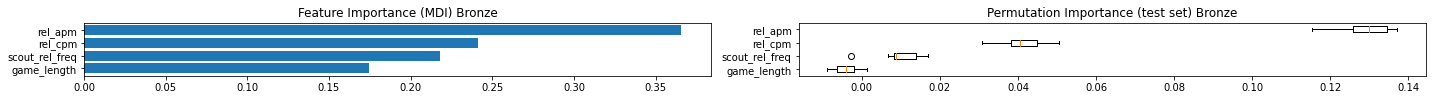

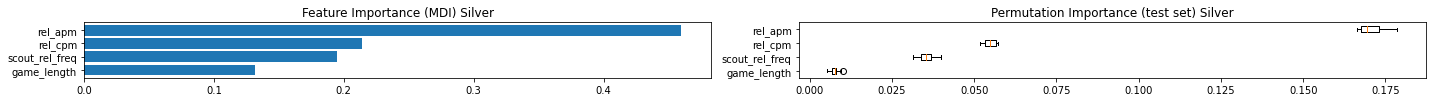

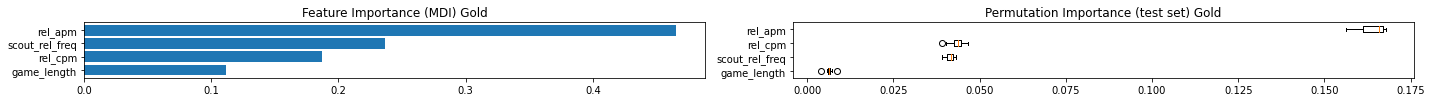

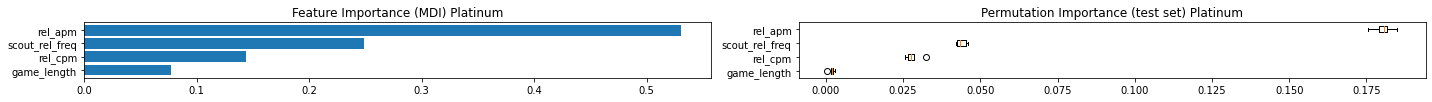

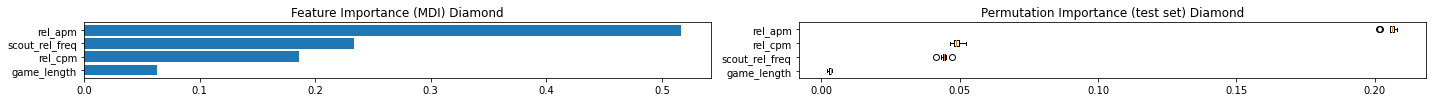

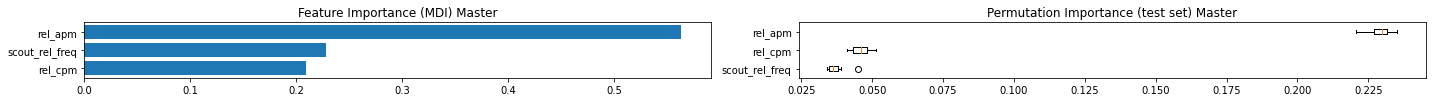

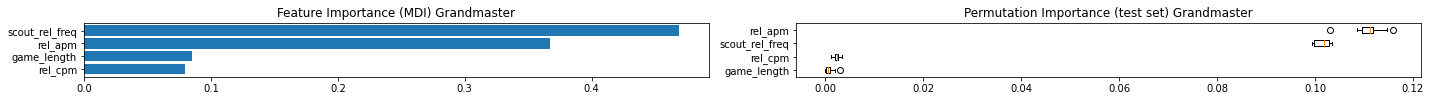

In [220]:
plot_features_importance(res[:7], rank = True)

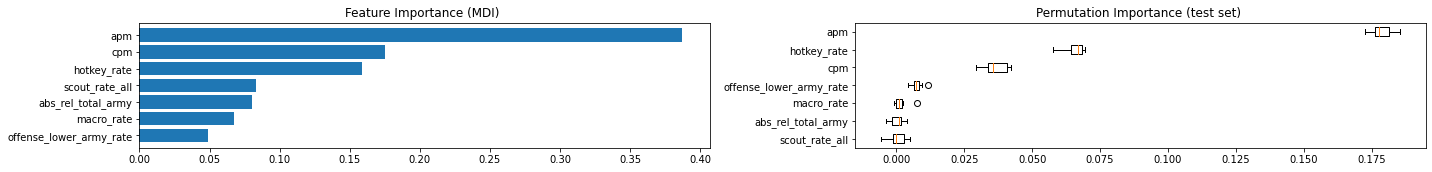

In [204]:
plot_features_importance(res, skill = True)

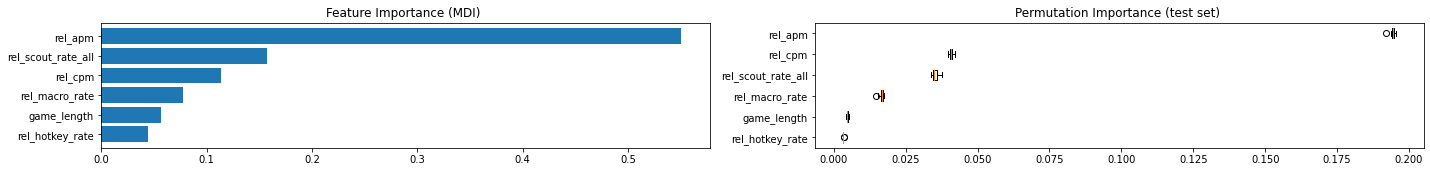

In [216]:
plot_features_importance(res[7:], skill = True)

In [132]:
res

[]

pandas.core.series.Series

multiclass


'multiclass'